In [3]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cuda:0


In [4]:
import string
import unicodedata

# We can use "_" to represent an out-of-vocabulary character, that is, any character we are not handling in our model
allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [5]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    # return our out-of-vocabulary character if we encounter a letter unknown to our model
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [6]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):

    def __init__(self, data_dir):
        self.data_dir = data_dir #for provenance of the dataset
        self.load_time = time.localtime #for provenance of the dataset
        labels_set = set() #set of all classes

        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []

        #read all the ``.txt`` files in the specified directory
        text_files = glob.glob(os.path.join(data_dir, '*.txt'))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)

        #Cache the tensor representation of the labels
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [7]:
alldata = NamesDataset("data/names")
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(train_set)}, validation examples = {len(test_set)}")

train examples = 17063, validation examples = 3011


In [8]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()

        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        rnn_out, hidden = self.rnn(line_tensor)
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [9]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [10]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input = lineToTensor('Albert')
output = rnn(input) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.9425, -2.7793, -2.7638, -2.9031, -2.8624, -2.7875, -2.8707, -2.8120,
         -2.9628, -2.8986, -2.8910, -2.9606, -2.8563, -2.8920, -3.0393, -2.8932,
         -3.0139, -2.9481]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Greek', 2)


In [16]:
import random
import numpy as np
import torch
import time
import torch.nn as nn

def evaluate_accuracy(rnn, test_data):
    rnn.eval()
    correct = 0
    with torch.no_grad():
        for label_tensor, text_tensor, _, _ in test_data:
            output = rnn(text_tensor)
            pred = torch.argmax(output, dim=1)
            if pred.item() == label_tensor.item():
                correct += 1
    rnn.train()
    return correct / len(test_data)

def train_and_evaluate(rnn, training_data, test_data, n_epoch=10, n_batch_size=64, report_every=1, learning_rate=0.2, criterion=nn.NLLLoss()):
    current_loss = 0
    all_losses = []
    all_accuracies = []

    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    start = time.time()
    print(f"Training on dataset of size: {len(training_data)}")

    for epoch in range(1, n_epoch + 1):
        rnn.zero_grad()
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, max(1, len(batches) // n_batch_size))

        for batch in batches:
            batch_loss = 0
            for i in batch:
                label_tensor, text_tensor, _, _ = training_data[i]
                output = rnn(text_tensor)
                loss = criterion(output, label_tensor)
                batch_loss += loss

            batch_loss.backward()
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)
            optimizer.step()
            optimizer.zero_grad()
            current_loss += batch_loss.item() / len(batch)

        avg_loss = current_loss / len(batches)
        current_loss = 0
        all_losses.append(avg_loss)

        if epoch % report_every == 0:
            acc = evaluate_accuracy(rnn, test_data)
            all_accuracies.append(acc)
            print(f"Epoch {epoch}/{n_epoch} — Loss: {avg_loss:.4f} — Test Accuracy: {acc:.2%}")

    return all_losses, all_accuracies

In [17]:
losses, accuracies = train_and_evaluate(rnn, train_set, test_set)


Training on dataset of size: 17063
Epoch 1/10 — Loss: 0.4986 — Test Accuracy: 77.15%
Epoch 2/10 — Loss: 0.5107 — Test Accuracy: 77.18%
Epoch 3/10 — Loss: 0.5100 — Test Accuracy: 76.92%
Epoch 4/10 — Loss: 0.5067 — Test Accuracy: 76.88%
Epoch 5/10 — Loss: 0.5093 — Test Accuracy: 77.35%
Epoch 6/10 — Loss: 0.4932 — Test Accuracy: 76.62%
Epoch 7/10 — Loss: 0.5006 — Test Accuracy: 77.62%
Epoch 8/10 — Loss: 0.4858 — Test Accuracy: 76.29%
Epoch 9/10 — Loss: 0.4976 — Test Accuracy: 76.75%
Epoch 10/10 — Loss: 0.4931 — Test Accuracy: 77.08%


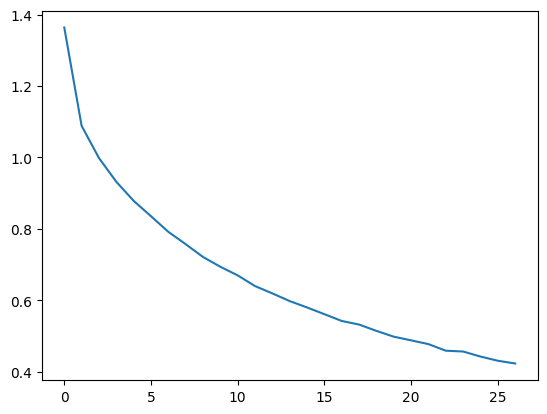

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

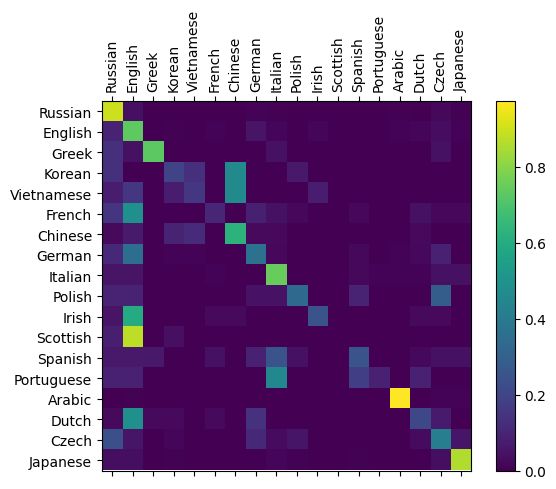

In [14]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_uniq)

In [15]:
def predict(name, rnn_model, labels_uniq):
    with torch.no_grad():  # disable gradient calculation
        rnn_model.eval()   # set model to eval mode
        input_tensor = lineToTensor(name)
        output = rnn_model(input_tensor)
        predicted_index = torch.argmax(output, dim=1).item()
        predicted_label = labels_uniq[predicted_index]
        return predicted_label
input = __builtins__.input  # restore original input function


prediction = predict("jack", rnn, train_set.dataset.labels_uniq)
print(f"Predicted label: {prediction}")


Predicted label: Czech
